In [ ]:
using CSV
using DataFrames
using Plots
using GLMNet
using Random
using Statistics
using MLBase
using NearestNeighbors
using LIBSVM
using StatsBase

# Obtención de los datos

#### Obtenemos los datos de python instalando la libreria necesaria y guardando en archivo como csv para cargarlo localmente en julia

In [ ]:
datos_market = DataFrame(CSV.read("stock_market.csv", DataFrame))

@show(datos_market)
println()

datos_market = 1250×9 DataFrame
  Row │ Year   Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today    Direction
      │ Int64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  String7
──────┼─────────────────────────────────────────────────────────────────────────────────
    1 │  2001    0.381   -0.192   -2.624   -1.055    5.01   1.1913     0.959  Up
    2 │  2001    0.959    0.381   -0.192   -2.624   -1.055  1.2965     1.032  Up
    3 │  2001    1.032    0.959    0.381   -0.192   -2.624  1.4112    -0.623  Down
    4 │  2001   -0.623    1.032    0.959    0.381   -0.192  1.276      0.614  Up
    5 │  2001    0.614   -0.623    1.032    0.959    0.381  1.2057     0.213  Up
    6 │  2001    0.213    0.614   -0.623    1.032    0.959  1.3491     1.392  Up
    7 │  2001    1.392    0.213    0.614   -0.623    1.032  1.445     -0.403  Down
    8 │  2001   -0.403    1.392    0.213    0.614   -0.623  1.4078     0.027  Up
    9 │  2001    0.027   -0.403    1.392    0.213    

# Exploración de los datos

Mostramos los datos de la base, asi como su tipo de datos de cada columna y los nombres de las columnas.

In [ ]:
@show(describe(datos_market))
@show(names(datos_market))
println()

describe(datos_market) = 9×7 DataFrame
 Row │ variable   mean       min      median   max      nmissing  eltype
     │ Symbol     Union…     Any      Union…   Any      Int64     DataType
─────┼─────────────────────────────────────────────────────────────────────
   1 │ Year       2003.02    2001     2003.0   2005            0  Int64
   2 │ Lag1       0.0038344  -4.922   0.039    5.733           0  Float64
   3 │ Lag2       0.0039192  -4.922   0.039    5.733           0  Float64
   4 │ Lag3       0.001716   -4.922   0.0385   5.733           0  Float64
   5 │ Lag4       0.001636   -4.922   0.0385   5.733           0  Float64
   6 │ Lag5       0.0056096  -4.922   0.0385   5.733           0  Float64
   7 │ Volume     1.4783     0.35607  1.42295  3.15247         0  Float64
   8 │ Today      0.0031384  -4.922   0.0385   5.733           0  Float64
   9 │ Direction             Down              Up              0  String7
names(datos_market) = ["Year", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "V

Verificamos si existen datos faltantes en cada columna:

In [ ]:
#verificar si hay datos faltantes
println("DATOS FALTANTES EN CADA COLUMNA:")
for (nombre, columna) in zip(names(datos_market), eachcol(datos_market))
	println(nombre, ":", count(ismissing, columna))
end

DATOS FALTANTES EN CADA COLUMNA:
Year:0
Lag1:0
Lag2:0
Lag3:0
Lag4:0
Lag5:0
Volume:0
Today:0
Direction:0


Dado que no hay ningún dato faltante, procedemos a cambiar el tipo de dato de la columna objetivo llamda Direction, contamos el numero de datos de cada clase y podmeos ver  continuación que no hay problemas conn clases desbalanceadas.

In [ ]:
#Contar la cantidad de valores unicos en la columna objetivo
countmap(datos_market.Direction)

Dict{String7, Int64} with 2 entries:
  "Up"   => 648
  "Down" => 602

# OneHotEncoding para las variables categoricas

In [ ]:
#Cambiar la columna Direction por 0 y 1
mapa_Direction = Dict("Up" => 1, "Down" => 0)
datos_market.Direction .= map(x -> mapa_Direction[string(x)], datos_market.Direction)

1250-element Vector{Int64}:
 1
 1
 0
 1
 1
 1
 0
 1
 1
 1
 ⋮
 0
 0
 1
 1
 1
 0
 1
 0
 0

In [ ]:
@show(datos_market)
println()

datos_market = 1250×9 DataFrame
  Row │ Year   Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today    Direction
      │ Int64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Int64
──────┼─────────────────────────────────────────────────────────────────────────────────
    1 │  2001    0.381   -0.192   -2.624   -1.055    5.01   1.1913     0.959          1
    2 │  2001    0.959    0.381   -0.192   -2.624   -1.055  1.2965     1.032          1
    3 │  2001    1.032    0.959    0.381   -0.192   -2.624  1.4112    -0.623          0
    4 │  2001   -0.623    1.032    0.959    0.381   -0.192  1.276      0.614          1
    5 │  2001    0.614   -0.623    1.032    0.959    0.381  1.2057     0.213          1
    6 │  2001    0.213    0.614   -0.623    1.032    0.959  1.3491     1.392          1
    7 │  2001    1.392    0.213    0.614   -0.623    1.032  1.445     -0.403          0
    8 │  2001   -0.403    1.392    0.213    0.614   -0.623  1.4078     0.027          1
   

# Dividir datos en entrenamiento y prueba

In [ ]:
# Dividir en entrenamiento y prueba
shuffle!(datos_market) #para revolver las filas
tamano_train = Int(0.7 * nrow(datos_market))
datos_train = datos_market[1:tamano_train, :]
datos_test = datos_market[tamano_train+1:end, :]
println()

In [ ]:
# Convertir los datos a matrices para que Flux los procese correctamente
X_train = (Matrix(select(datos_train, Not(:Direction))))  # Los datos de entrada de entrenamiento
y_train = vec(Matrix(select(datos_train, :Direction)))  # Las etiquetas de entrenamiento (sin necesidad de convertir a Matrix)
X_test = (Matrix(select(datos_test, Not(:Direction))))  # Los datos de entrada de prueba
y_test = vec(Matrix(select(datos_test, :Direction))) # Las etiquetas de prueba (sin necesidad de convertir a Matrix)

println("Dimención de datos entrenamiento (X): ",size(X_train))
println("Dimención de datos entrenamiento (y): ", size(y_train))
println("Dimención de datos prueba (X): ", size(X_test))
println("Dimención de datos prueba (X): ", size(y_test))

Dimención de datos entrenamiento (X): (875, 8)
Dimención de datos entrenamiento (y): (875,)
Dimención de datos prueba (X): (375, 8)
Dimención de datos prueba (X): (375,)


Para los siguientes 3 metodos, podemos notar que en las funciones que utilizaremos, solo debemos de cambiar el valor de $\lambda$ cuyo significado esta en la función de costo a minimizar en el problema dado, el problema de minimización es:

$$
\mathcal{L}(\beta) = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2
+ \lambda \left( \alpha \sum_{j=1}^{p} |\beta_j| + (1 - \alpha) \sum_{j=1}^{p} \beta_j^2 \right)
$$

### Componentes
1. **Pérdida de error ( en este caso, el error cuadrático medio)**:
   $$
   \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2
   $$

2. **Término de regularización**:
   $$
   \lambda \left( \alpha \sum_{j=1}^{p} |\beta_j| + (1 - \alpha) \sum_{j=1}^{p} \beta_j^2 \right) = \lambda \left( \alpha \|\beta\|_1 + (1 - \alpha) \|\beta\|_2^2 \right)
   $$
   - $ \alpha \sum_{j=1}^{p} |\beta_j| $: Regularización $L_1$ (Lasso).
   - $ (1 - \alpha) \sum_{j=1}^{p} \beta_j^2 $: Regularización $L_2$ (Ridge).

3. **Parámetros:**
   - $\alpha$: Balance entre $L_1$ y $L_2$:
     - $\alpha = 1$: Tenemos $L_1$ (Lasso).
     - $\alpha = 0$: Tenemos $L_2$ (Ridge).
     - $0 < \alpha < 1$: Combinación de $L_1$ y $L_2$ (Elastic Net).
   - $\lambda$: Intensidad de la penalización ($\lambda > 0$).

# 1.LASSO
1. **Lasso ($\alpha = 1$)**:
   $$
   \mathcal{L}(\beta) = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j|
   $$

In [ ]:
# Validación cruzada para seleccionar el mejor modelo
cv_modelo = GLMNet.glmnetcv(X_train, y_train, alpha=1)

Least Squares GLMNet Cross Validation
67 models for 8 predictors in 10 folds
Best λ 0.013 (mean loss 0.115, std 0.004)

In [ ]:
# Obtener el mejor valor de λ y coeficientes
mejor_lambda = cv_modelo.lambda[argmin(cv_modelo.meanloss)]

# Obtener la trayectoria de coeficientes
coef = GLMNet.coef(cv_modelo)
println("Coeficientes: ", coef)

Coeficientes: [0.014299321563230591, -0.013480696709221751, 0.0, 0.0, 0.0, 0.0008665924816086414, 0.0, 0.311966211944906]


In [ ]:
prediccion = round.(GLMNet.predict(cv_modelo, X_test, outtype = :prob), digits=3);
DataFrame(clas_correc = y_test, pred_prob = prediccion)

375×2 DataFrame
 Row │ clas_correc  pred_prob 
     │ Int64        Float64   
─────┼────────────────────────
   1 │           1      0.709
   2 │           0      0.196
   3 │           1      0.715
   4 │           0      0.259
   5 │           0      0.352
   6 │           0      0.473
   7 │           0      0.087
   8 │           1      0.932
  ⋮  │      ⋮           ⋮
 369 │           1      0.822
 370 │           1      0.613
 371 │           1      0.628
 372 │           0      0.217
 373 │           1      0.654
 374 │           1      0.794
 375 │           1      0.544
              360 rows omitted

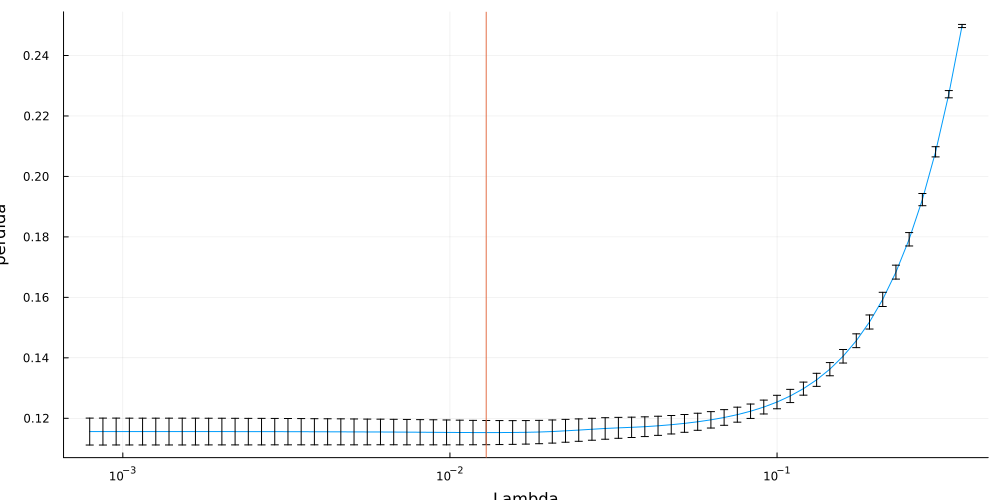

In [ ]:
Plots.plot(cv_modelo.lambda, cv_modelo.meanloss, xscale=:log10, legend=false, yerror=cv_modelo.stdloss,xlabel="Lambda",ylabel="perdida")
Plots.vline!([lambdamin(cv_modelo)], size = (1000,500))

In [ ]:
# Convertir probabilidades en clases (0 o 1)
#umbral de 0.5
prediccion_clase = [if x < 0.5 0 else 1 end for x in prediccion];

prediccion_df = DataFrame(y_actual = datos_test.Direction, y_predicha = prediccion_clase, prob_predicha = prediccion);
prediccion_df.clasificacion_corecta = prediccion_df.y_actual .== prediccion_df.y_predicha;

### Matriz de Confusión

In [ ]:
matriz_confusion = MLBase.roc(prediccion_df.y_actual, prediccion_df.y_predicha)
println(matriz_confusion)

ROCNums{Int64}
  p = 203
  n = 172
  tp = 198
  tn = 161
  fp = 11
  fn = 5



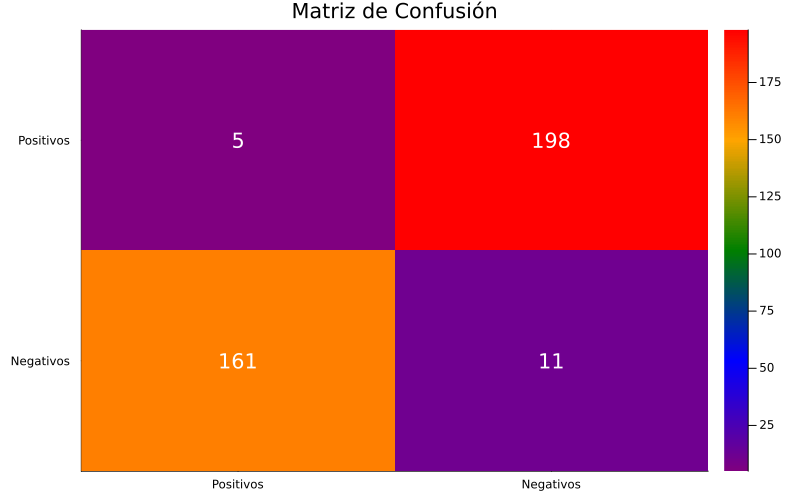

In [ ]:
# Extraer valores del objeto confusion_matrix
tp = matriz_confusion.tp  # Verdaderos Positivos
tn = matriz_confusion.tn  # Verdaderos Negativos
fp = matriz_confusion.fp  # Falsos Positivos
fn = matriz_confusion.fn  # Falsos Negativos

# Construir la matriz de confusión
m_c = [tn fp; fn tp]


for i in 1:size(m_c, 1)
    for j in 1:size(m_c, 2)
        annotate!(j, i, Plots.text(string(m_c[i, j]), :white, 14))
    end
end


# Coordenadas de los cuadros para las anotaciones
rows, cols = size(m_c)
x_coord = repeat(1:cols, inner=rows)
y_coord = repeat(1:rows, outer=cols)

# Texto con los valores de la matriz
texto = vec(string.(m_c))

# Graficar la matriz de confusión
Plots.heatmap(
    m_c,
    title="Matriz de Confusión",
    #xlabel="Predicción",
    #ylabel="Actual",
    c=:rainbow,
    xticks=(1:2, ["Positivos", "Negativos"]),
    yticks=(1:2, ["Negativos", "Positivos"]),
    colorbar=true,
    annotations=(x_coord, y_coord, texto, :white),
    size=(800, 500)
)

In [ ]:
println("Exactitud = ", (tp + tn) / (tp + tn + fp + fn))
println("Sensibilidad = ", tp / (tp + fn))
println("Especificidad = ", tn / (tn + fp))

Exactitud = 0.9573333333333334
Sensibilidad = 0.9753694581280788
Especificidad = 0.936046511627907


### ROC y AUC

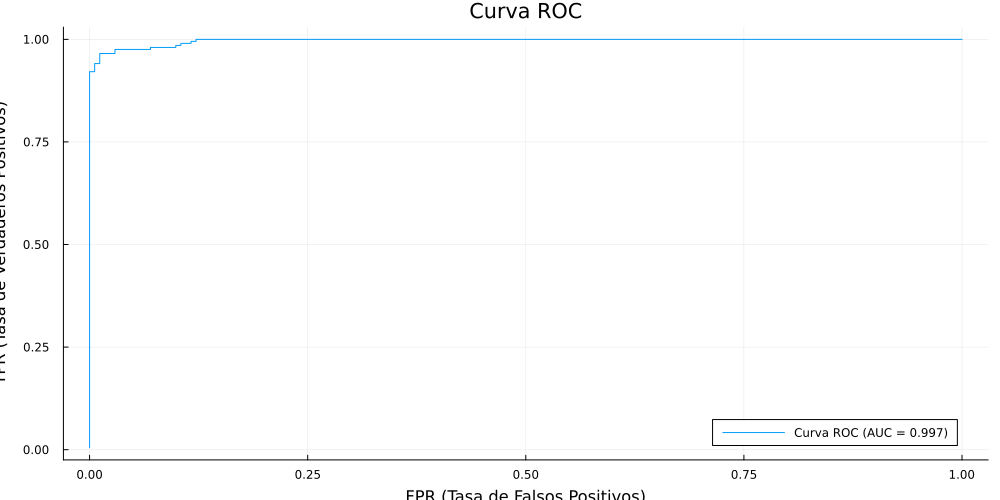

In [ ]:
function plot_roc_from_predictions(y_actual::Vector{Int}, y_prob::Vector{Float64})
    # Ordenar por probabilidades predichas en orden descendente
    sorted_indices = sortperm(y_prob, rev=true)
    sorted_probs = y_prob[sorted_indices]
    sorted_labels = y_actual[sorted_indices]

    # Inicializar variables
    tpr = Float64[]  # Verdadero positivo rate (True Positive Rate)
    fpr = Float64[]  # Falso positivo rate (False Positive Rate)
    tp = 0
    fp = 0
    p = sum(sorted_labels)  # Total de positivos
    n = length(sorted_labels) - p  # Total de negativos

    # Calcular TPR y FPR en cada umbral
    for i in 1:length(sorted_probs)
        if sorted_labels[i] == 1
            tp += 1
        else
            fp += 1
        end
        push!(tpr, tp / p)
        push!(fpr, fp / n)
    end

    # Calcular AUC usando la regla trapezoidal
    auc = sum((tpr[2:end] + tpr[1:end-1]) .* (fpr[1:end-1] - fpr[2:end])) / 2

    # Graficar curva ROC
    plot(fpr, tpr, label="Curva ROC (AUC = $(abs(round(auc, digits=3))))",
         xlabel="FPR (Tasa de Falsos Positivos)",
         ylabel="TPR (Tasa de Verdaderos Positivos)",
         title="Curva ROC",
         legend=:bottomright)
end

Plots.plot(
    plot_roc_from_predictions(y_test, prediccion),
    size=(1000, 500)
)

# 2.Ridge
2. **Ridge ($\alpha = 0$)**:
   $$
   \mathcal{L}(\beta) = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
   $$

Mejor lambda: 0.0367664715481924
Coeficientes: [0.02595584349957965, -0.023200040450194106, -0.006356971450375033, 0.0067931460090759595, 0.009217931954013122, 0.011487321214995327, -0.03123596633739373, 0.3016332440388979]

375×2 DataFrame
 Row │ clas_correc  pred_prob 
     │ Int64        Float64   
─────┼────────────────────────
   1 │           1      0.741
   2 │           0      0.187
   3 │           1      0.733
   4 │           0      0.269
   5 │           0      0.381
   6 │           0      0.488
   7 │           0      0.128
   8 │           1      0.972
   9 │           1      0.495
  10 │           1      0.612
  11 │           0      0.506
  12 │           0      0.392
  13 │           1      0.796
  14 │           1      0.805
  15 │           0      0.261
  16 │           0      0.199
  17 │           0      0.279
  18 │           0      0.493
  19 │           1      0.605
  20 │           1      0.704
  21 │           0      0.087
  22 │           1      0.531
  23 │

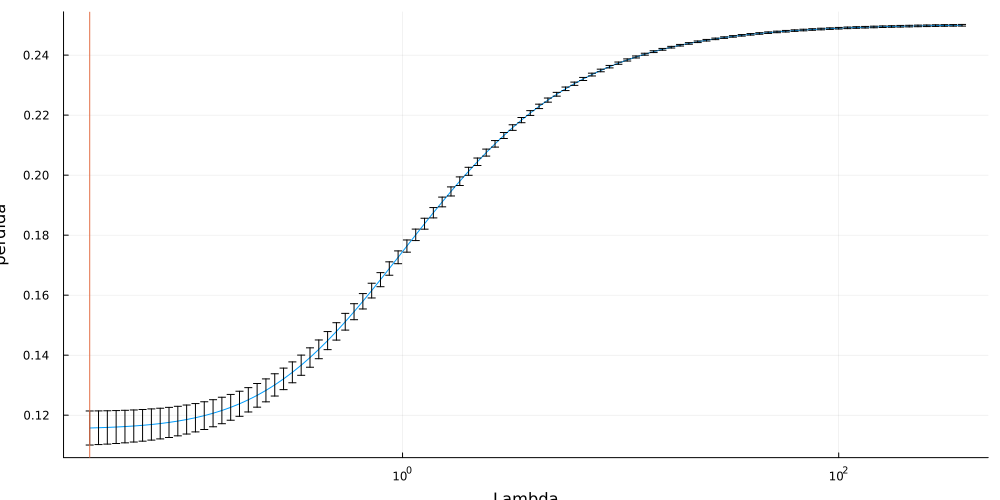

In [ ]:
# Validación cruzada para seleccionar el mejor modelo
cv_modelo = GLMNet.glmnetcv(X_train, y_train, alpha=0)
# Obtener el mejor valor de λ y coeficientes
mejor_lambda = cv_modelo.lambda[argmin(cv_modelo.meanloss)]
println("Mejor lambda: ", mejor_lambda)

# Obtener la trayectoria de coeficientes
coef = GLMNet.coef(cv_modelo)
println("Coeficientes: ", coef)
println()

prediccion = round.(GLMNet.predict(cv_modelo, X_test, outtype = :prob), digits=3);
println(DataFrame(clas_correc = y_test, pred_prob = prediccion))


Plots.plot(cv_modelo.lambda, cv_modelo.meanloss, xscale=:log10, legend=false, yerror=cv_modelo.stdloss,xlabel="Lambda",ylabel="perdida")
Plots.vline!([lambdamin(cv_modelo)], size = (1000,500))

In [ ]:
# Convertir probabilidades en clases (0 o 1)
#umbral de 0.5
prediccion_clase = [if x < 0.5 0 else 1 end for x in prediccion];

prediccion_df = DataFrame(y_actual = datos_test.Direction, y_predicha = prediccion_clase, prob_predicha = prediccion);
prediccion_df.clasificacion_corecta = prediccion_df.y_actual .== prediccion_df.y_predicha;

In [ ]:
matriz_confusion = MLBase.roc(prediccion_df.y_actual, prediccion_df.y_predicha)
println(matriz_confusion)

ROCNums{Int64}
  p = 203
  n = 172
  tp = 195
  tn = 158
  fp = 14
  fn = 8



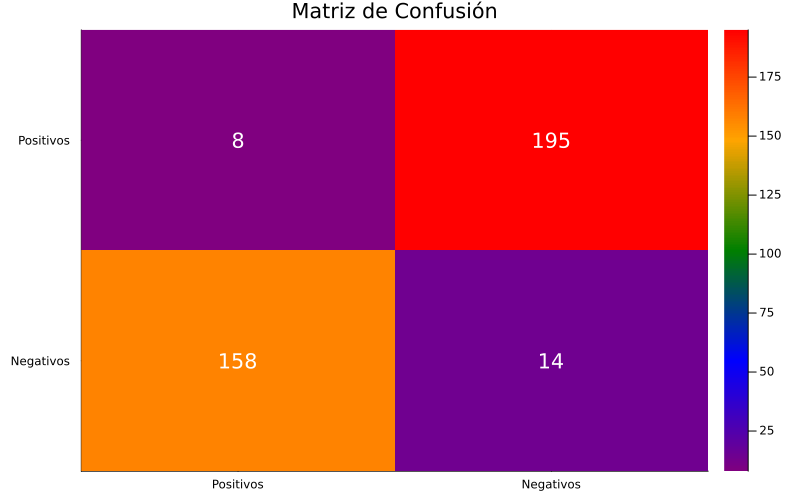

In [ ]:
# Extraer valores del objeto confusion_matrix
tp = matriz_confusion.tp  # Verdaderos Positivos
tn = matriz_confusion.tn  # Verdaderos Negativos
fp = matriz_confusion.fp  # Falsos Positivos
fn = matriz_confusion.fn  # Falsos Negativos

# Construir la matriz de confusión
m_c = [tn fp; fn tp]


for i in 1:size(m_c, 1)
    for j in 1:size(m_c, 2)
        annotate!(j, i, Plots.text(string(m_c[i, j]), :white, 14))
    end
end


# Coordenadas de los cuadros para las anotaciones
rows, cols = size(m_c)
x_coord = repeat(1:cols, inner=rows)
y_coord = repeat(1:rows, outer=cols)

# Texto con los valores de la matriz
texto = vec(string.(m_c))

# Graficar la matriz de confusión
Plots.heatmap(
    m_c,
    title="Matriz de Confusión",
    #xlabel="Predicción",
    #ylabel="Actual",
    c=:rainbow,
    xticks=(1:2, ["Positivos", "Negativos"]),
    yticks=(1:2, ["Negativos", "Positivos"]),
    colorbar=true,
    annotations=(x_coord, y_coord, texto, :white),
    size=(800, 500)
)

In [ ]:
println("Exactitud = ", (tp + tn) / (tp + tn + fp + fn))
println("Sensibilidad = ", tp / (tp + fn))
println("Especificidad = ", tn / (tn + fp))

Exactitud = 0.9413333333333334
Sensibilidad = 0.9605911330049262
Especificidad = 0.9186046511627907


### ROC y AUC

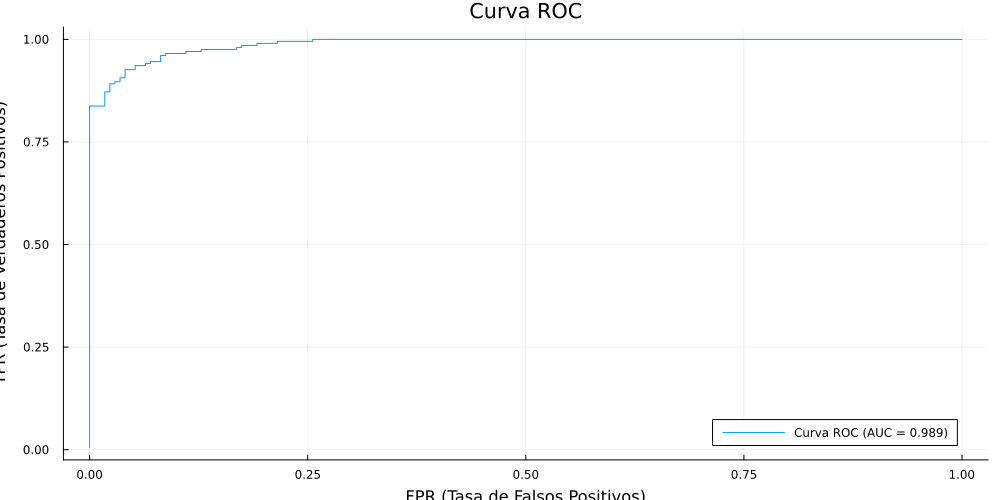

In [ ]:
Plots.plot(
    plot_roc_from_predictions(y_test, prediccion),
    size=(1000, 500)
)

# 3.Elastic Net
3. **Elastic Net ($0 < \alpha < 1$), seleccionamos $\alpha=0.5$**:
   $$
   \mathcal{L}(\beta) = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \left( 0.5 \sum_{j=1}^{p} |\beta_j| + (1 - 0.5) \sum_{j=1}^{p} \beta_j^2 \right)
   $$

Mejor lambda: 0.0014434815641530144
Coeficientes: [0.027049718363274883, -0.024202939582766064, -0.005618668497184778, 0.0068882475178522985, 0.010137096720778891, 0.012876479838128603, -0.03508038296558985, 0.32281848543080394]

375×2 DataFrame
 Row │ clas_correc  pred_prob 
     │ Int64        Float64   
─────┼────────────────────────
   1 │           1      0.755
   2 │           0      0.165
   3 │           1      0.745
   4 │           0      0.254
   5 │           0      0.371
   6 │           0      0.484
   7 │           0      0.102
   8 │           1      1.003
   9 │           1      0.497
  10 │           1      0.618
  11 │           0      0.507
  12 │           0      0.385
  13 │           1      0.816
  14 │           1      0.826
  15 │           0      0.242
  16 │           0      0.179
  17 │           0      0.259
  18 │           0      0.489
  19 │           1      0.614
  20 │           1      0.716
  21 │           0      0.058
  22 │           1      0.536
 

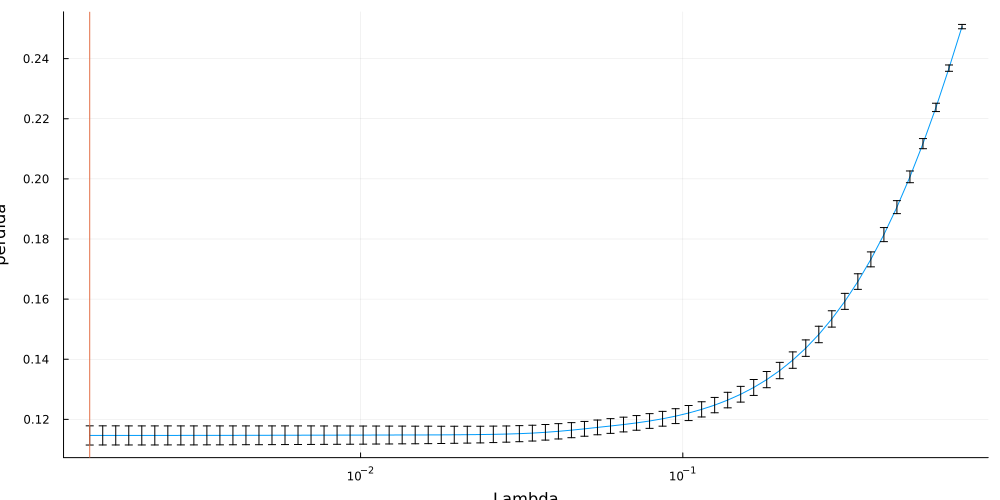

In [ ]:
# Validación cruzada para seleccionar el mejor modelo
cv_modelo = GLMNet.glmnetcv(X_train, y_train, alpha=0.5)
# Obtener el mejor valor de λ y coeficientes
mejor_lambda = cv_modelo.lambda[argmin(cv_modelo.meanloss)]
println("Mejor lambda: ", mejor_lambda)

# Obtener la trayectoria de coeficientes
coef = GLMNet.coef(cv_modelo)
println("Coeficientes: ", coef)
println()

prediccion = round.(GLMNet.predict(cv_modelo, X_test, outtype = :prob), digits=3);
println(DataFrame(clas_correc = y_test, pred_prob = prediccion))


Plots.plot(cv_modelo.lambda, cv_modelo.meanloss, xscale=:log10, legend=false, yerror=cv_modelo.stdloss,xlabel="Lambda",ylabel="perdida")
Plots.vline!([lambdamin(cv_modelo)], size = (1000,500))

In [ ]:
# Convertir probabilidades en clases (0 o 1)
#umbral de 0.5
prediccion_clase = [if x < 0.5 0 else 1 end for x in prediccion];

prediccion_df = DataFrame(y_actual = datos_test.Direction, y_predicha = prediccion_clase, prob_predicha = prediccion);
prediccion_df.clasificacion_corecta = prediccion_df.y_actual .== prediccion_df.y_predicha;

### Matriz de Confusión

In [ ]:
matriz_confusion = MLBase.roc(prediccion_df.y_actual, prediccion_df.y_predicha)
println(matriz_confusion)

ROCNums{Int64}
  p = 203
  n = 172
  tp = 195
  tn = 158
  fp = 14
  fn = 8



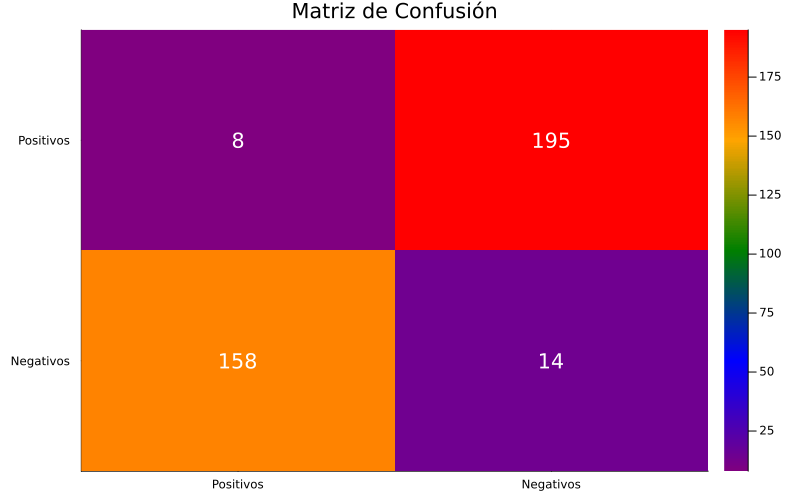

In [ ]:
# Extraer valores del objeto confusion_matrix
tp = matriz_confusion.tp  # Verdaderos Positivos
tn = matriz_confusion.tn  # Verdaderos Negativos
fp = matriz_confusion.fp  # Falsos Positivos
fn = matriz_confusion.fn  # Falsos Negativos

# Construir la matriz de confusión
m_c = [tn fp; fn tp]


for i in 1:size(m_c, 1)
    for j in 1:size(m_c, 2)
        annotate!(j, i, Plots.text(string(m_c[i, j]), :white, 14))
    end
end


# Coordenadas de los cuadros para las anotaciones
rows, cols = size(m_c)
x_coord = repeat(1:cols, inner=rows)
y_coord = repeat(1:rows, outer=cols)

# Texto con los valores de la matriz
texto = vec(string.(m_c))

# Graficar la matriz de confusión
Plots.heatmap(
    m_c,
    title="Matriz de Confusión",
    #xlabel="Predicción",
    #ylabel="Actual",
    c=:rainbow,
    xticks=(1:2, ["Positivos", "Negativos"]),
    yticks=(1:2, ["Negativos", "Positivos"]),
    colorbar=true,
    annotations=(x_coord, y_coord, texto, :white),
    size=(800, 500)
)

In [ ]:
println("Exactitud = ", (tp + tn) / (tp + tn + fp + fn))
println("Sensibilidad = ", tp / (tp + fn))
println("Especificidad = ", tn / (tn + fp))

Exactitud = 0.9413333333333334
Sensibilidad = 0.9605911330049262
Especificidad = 0.9186046511627907


### ROC y AUC

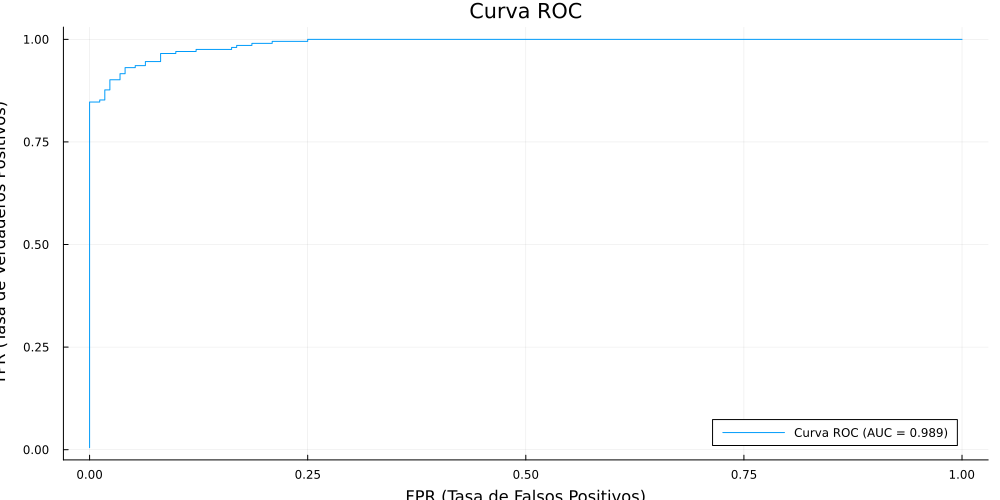

In [ ]:
Plots.plot(
    plot_roc_from_predictions(y_test, prediccion),
    size=(1000, 500)
)

# 4.Decision Tree


In [ ]:
using DecisionTree

In [ ]:
# Construir un árbol de decisión
modelo_arbol = DecisionTree.build_tree(y_train, X_train)
modelo_arbol = prune_tree(modelo_arbol, 0.9)
DecisionTree.print_tree(modelo_arbol, 3)

#Aplicar el modelo al conjunto de prueba
prediccion = apply_tree(modelo_arbol, X_test)

Feature 8 < -0.0005 ?
├─ 0 : 430/430
└─ 1 : 445/445


375-element Vector{Int64}:
 1
 0
 1
 0
 0
 0
 0
 1
 1
 1
 ⋮
 0
 0
 1
 1
 1
 0
 1
 1
 1

### Matriz de confusión

In [ ]:
matriz_confusion = MLBase.roc(datos_test.Direction, prediccion)
println(matriz_confusion)

ROCNums{Int64}
  p = 203
  n = 172
  tp = 203
  tn = 172
  fp = 0
  fn = 0



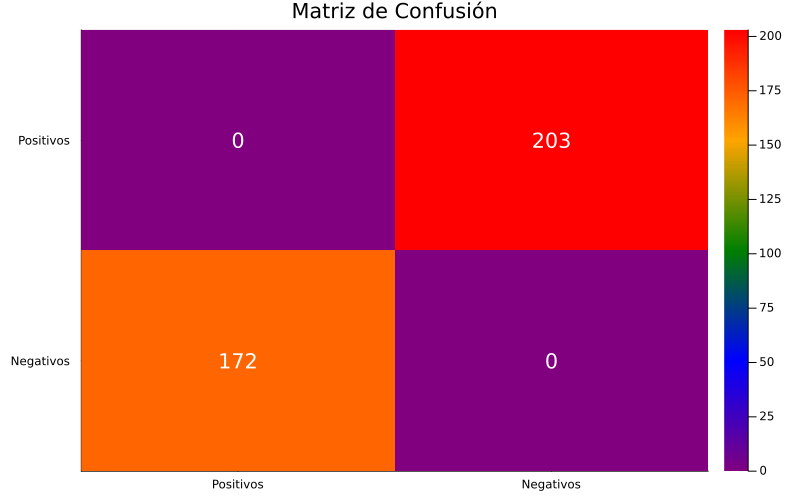

In [ ]:
# Extraer valores del objeto confusion_matrix
tp = matriz_confusion.tp  # Verdaderos Positivos
tn = matriz_confusion.tn  # Verdaderos Negativos
fp = matriz_confusion.fp  # Falsos Positivos
fn = matriz_confusion.fn  # Falsos Negativos

# Construir la matriz de confusión
m_c = [tn fp; fn tp]


for i in 1:size(m_c, 1)
    for j in 1:size(m_c, 2)
        annotate!(j, i, Plots.text(string(m_c[i, j]), :white, 14))
    end
end


# Coordenadas de los cuadros para las anotaciones
rows, cols = size(m_c)
x_coord = repeat(1:cols, inner=rows)
y_coord = repeat(1:rows, outer=cols)

# Texto con los valores de la matriz
texto = vec(string.(m_c))

# Graficar la matriz de confusión
Plots.heatmap(
    m_c,
    title="Matriz de Confusión",
    #xlabel="Predicción",
    #ylabel="Actual",
    c=:rainbow,
    xticks=(1:2, ["Positivos", "Negativos"]),
    yticks=(1:2, ["Negativos", "Positivos"]),
    colorbar=true,
    annotations=(x_coord, y_coord, texto, :white),
    size=(800, 500)
)

In [ ]:
println("Exactitud = ", (tp + tn) / (tp + tn + fp + fn))
println("Sensibilidad = ", tp / (tp + fn))
println("Especificidad = ", tn / (tn + fp))

Exactitud = 1.0
Sensibilidad = 1.0
Especificidad = 1.0


### ROC y AUC

# 5.Random Forest

In [ ]:
# Usando 2 características aleatorias, 10 árboles, 50% de muestras por árbol y una profundidad máxima de 6
modelo_bosque = DecisionTree.build_forest(y_train, X_train, 2, 10, 0.5, 6)
# Obtener la probabilidad de cada clase
probabilidades = DecisionTree.apply_forest_proba(modelo_bosque, X_test, [0,1])

# Predicción binaria basada en el umbral
predicciones = [fila[2] >= 0.5 ? 1 : 0 for fila in eachrow(probabilidades)]

# Realizar validación cruzada de 4 particiones para el bosque, usando 2 características aleatorias por división
exactitud = nfoldCV_forest(y_train, X_train, 4, 2)


Fold 1
Classes:  [0, 1]
Matrix:   
Accuracy: 0.9954128440366973
Kappa:    0.990821052631579

Fold 2
Classes:  [0, 1]
Matrix:   
Accuracy: 1.0
Kappa:    1.0

Fold 3
Classes:  [0, 1]
Matrix:   
Accuracy: 0.9954128440366973
Kappa:    0.9908241434464181

Fold 4
Classes:  [0, 1]
Matrix:   
Accuracy: 0.9954128440366973
Kappa:    0.9907226146906121

Mean Accuracy: 0.996559633027523


2×2 Matrix{Int64}:
 111    1
   0  106

2×2 Matrix{Int64}:
 111    0
   0  107

2×2 Matrix{Int64}:
 107    1
   0  110

2×2 Matrix{Int64}:
 97    0
  1  120

4-element Vector{Float64}:
 0.9954128440366973
 1.0
 0.9954128440366973
 0.9954128440366973

In [ ]:
# Asegúrate de que las predicciones estén en formato adecuado
predicciones_binarias = Int.(predicciones)

# Comparar las predicciones con las etiquetas reales
matriz_confusion = MLBase.roc(datos_test.Direction, predicciones_binarias)

# Imprimir la matriz de confusión
println(matriz_confusion)

ROCNums{Int64}
  p = 203
  n = 172
  tp = 203
  tn = 169
  fp = 3
  fn = 0



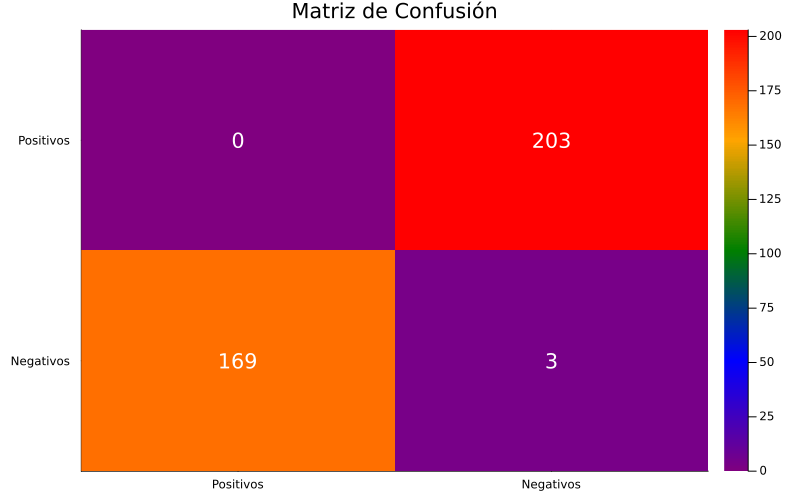

In [ ]:
# Extraer valores del objeto confusion_matrix
tp = matriz_confusion.tp  # Verdaderos Positivos
tn = matriz_confusion.tn  # Verdaderos Negativos
fp = matriz_confusion.fp  # Falsos Positivos
fn = matriz_confusion.fn  # Falsos Negativos

# Construir la matriz de confusión
m_c = [tn fp; fn tp]


for i in 1:size(m_c, 1)
    for j in 1:size(m_c, 2)
        annotate!(j, i, Plots.text(string(m_c[i, j]), :white, 14))
    end
end


# Coordenadas de los cuadros para las anotaciones
rows, cols = size(m_c)
x_coord = repeat(1:cols, inner=rows)
y_coord = repeat(1:rows, outer=cols)

# Texto con los valores de la matriz
texto = vec(string.(m_c))

# Graficar la matriz de confusión
Plots.heatmap(
    m_c,
    title="Matriz de Confusión",
    #xlabel="Predicción",
    #ylabel="Actual",
    c=:rainbow,
    xticks=(1:2, ["Positivos", "Negativos"]),
    yticks=(1:2, ["Negativos", "Positivos"]),
    colorbar=true,
    annotations=(x_coord, y_coord, texto, :white),
    size=(800, 500)
)

In [ ]:
println("Exactitud = ", (tp + tn) / (tp + tn + fp + fn))
println("Sensibilidad = ", tp / (tp + fn))
println("Especificidad = ", tn / (tn + fp))

Exactitud = 0.992
Sensibilidad = 1.0
Especificidad = 0.9825581395348837


# 6.Nearest Neighbors

In [ ]:
# Crear el índice KDTree para X_train
for k in 1:10
    knn_tree = KDTree(permutedims(X_train))

    index_knn, distances = NearestNeighbors.knn(knn_tree, permutedims(X_test), k, true)
    index_knn_matrix = hcat(index_knn...)
    index_knn_matrix_t = permutedims(index_knn_matrix)

    knn_classes = (y_train)[index_knn_matrix_t]

    y_hat = [
        argmax(countmap(knn_classes[i, :]))
        for i in 1:length(y_test)
    ]

    accuracy = sum(y_hat .== y_test) / length(y_test)

    println("Exactitud para k=", k ,": ", accuracy)
end

Exactitud para k=1: 0.8426666666666667
Exactitud para k=2: 0.8133333333333334
Exactitud para k=3: 0.864
Exactitud para k=4: 0.832
Exactitud para k=5: 0.888
Exactitud para k=6: 0.856
Exactitud para k=7: 0.888
Exactitud para k=8: 0.8613333333333333
Exactitud para k=9: 0.8746666666666667
Exactitud para k=10: 0.8693333333333333


uso el modelo para k = 3

In [ ]:
k=3
knn_tree = KDTree(permutedims(X_train))

index_knn, distances = NearestNeighbors.knn(knn_tree, permutedims(X_test), k, true)
index_knn_matrix = hcat(index_knn...)
index_knn_matrix_t = permutedims(index_knn_matrix)

knn_classes = (y_train)[index_knn_matrix_t]

y_hat = [
    argmax(countmap(knn_classes[i, :]))
    for i in 1:length(y_test)
]

accuracy = sum(y_hat .== y_test) / length(y_test)

println("Exactitud para k=", k ,": ", accuracy)

Exactitud para k=3: 0.864


# 7.Support Vector Machines (SVM)

In [ ]:
# Clasificación C-SVM
# Entrenamos el modelo con X_train y y_train
model_classification = LIBSVM.fit!(SVC(), X_train, y_train)

SVC(LIBSVM.Kernel.RadialBasis, 0.125, nothing, 1.0, 3, 0.0, 0.001, true, false, false, LIBSVM.SVM{Int64, LIBSVM.Kernel.KERNEL}(SVC, LIBSVM.Kernel.RadialBasis, nothing, 8, 875, 2, [1, 0], Int32[1, 2], Float64[], Int32[], LIBSVM.SupportVectors{Vector{Int64}, Matrix{Float64}}(333, Int32[166, 167], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2002.0 2001.0 … 2002.0 2004.0; 1.6880000000000002 0.246 … 0.733 -0.97; … ; 1.7961 1.5175 … 1.1864 1.3375; 5.408 0.158 … -0.0139999999999999 -0.196], Int32[1, 5, 11, 14, 16, 18, 22, 26, 34, 41  …  834, 850, 852, 855, 858, 859, 865, 867, 872, 874], LIBSVM.SVMNode[LIBSVM.SVMNode(1, 2002.0), LIBSVM.SVMNode(1, 2001.0), LIBSVM.SVMNode(1, 2005.0), LIBSVM.SVMNode(1, 2002.0), LIBSVM.SVMNode(1, 2003.0), LIBSVM.SVMNode(1, 2001.0), LIBSVM.SVMNode(1, 2001.0), LIBSVM.SVMNode(1, 2002.0), LIBSVM.SVMNode(1, 2001.0), LIBSVM.SVMNode(1, 2005.0)  …  LIBSVM.SVMNode(1, 2005.0), LIBSVM.SVMNode(1, 2005.0), LIBSVM.SVMNode(1, 2001.0), LIBSVM.SVMNode(1, 2003

In [ ]:
# Realizamos la predicción sobre X_test
ŷ_classification = LIBSVM.predict(model_classification, X_test)

# Epsilon-Regression
# Para la regresión, necesitas ajustar el formato de X (debe ser una matriz de una sola columna en este caso)
# Asegurémonos de que X_train y X_test tengan las dimensiones correctas
X_train_regression = Matrix(X_train[:, 1:1])  # Suponiendo que solo usas la primera columna para la regresión
X_test_regression = Matrix(X_test[:, 1:1])

# Ajuste del modelo para la regresión
model_regression = LIBSVM.fit!(EpsilonSVR(cost = 10., gamma = 1.), X_train_regression, y_train)

# Predicción para los datos de prueba
ŷ_regression = LIBSVM.predict(model_regression, X_test_regression)

375-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
model_classification = LIBSVM.fit!(SVC(), X_train, y_train)

# Realizamos la predicción sobre X_test
ŷ_classification = LIBSVM.predict(model_classification, X_test)

# Calculamos el accuracy
accuracy = sum(ŷ_classification .== y_test) / length(y_test)

println("Precisión: ", accuracy)

Precisión: 0.9573333333333334
